## Demo pour la maquette

Ceci est un notebook de démo pour la simulation numérique de la maquette.

La maquette contient une couche en sable et une couche en bille. Des codes suivants vont simuler ces deux couches et faire sortir le diagramme de température en différentes profondeurs, étant donné les propriétés de chaque couche, la différence de charge variable, les conditions aux limites de température.

In [76]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [77]:
# pour faire des données adaptées pour l'objet colonne, il faut faire des datetimes

# définition onboard des séries de dates pour ne pas dépendre de mesures extérieures avec choix des dates
dt = datetime(2010, 12, 1)
end = datetime(2010, 12, 30, 23, 59, 59)
step = timedelta(seconds=15*60)

times_vir1 = []
while dt < end:
    times_vir1.append(dt) # pas encore un objet datetime
    dt += step
times_vir1 = np.array(times_vir1) # TODO : mettre au format datetime 

#définition onboard des dates à partir de 1970 par défaut avec timestamp
n_len_times = 2000
times_vir2 = np.array([datetime.fromtimestamp(15*k) for k in range(n_len_times)])

times_vir = times_vir2 # choix de la méthode de datation
n_t = len(times_vir) # initialisation du nombre de pas de temps

In [78]:
# définition pas de temps pour faire les calculs
dt = 15*60 # pas de temps de 15mn
t_range = np.arange(n_t)*dt

# défintion signal de température rivière
# dont l'amplitude et la période seront déterminés pour que les signuax soient visibles
T_riv_amp = 2
T_riv_offset = 12
P_temp = 24*4*dt
T_riv_signal = T_riv_amp*np.cos(2*np.pi*t_range/P_temp) + T_riv_offset

# défintion signal de charge rivière
#La différence de charge varie de 10cm à -10cm au cours de 2 semaines, 
#ce qui est simulé par une fonction sinusoïdale de période de 28 jours.
dH_amp = 0.1
dH_offset = 0
P_dh = 14*24*4*dt
dH_signal = dH_amp*np.cos(2*np.pi*t_range/P_dh) + dH_offset

In [79]:
# définition des données de mesures au bon format
n_sens_vir = 5 #nombre de capteur

T_vir = np.zeros((n_t,n_sens_vir)) # le tableau qui accueille des données de températures de forçage
T_vir[:,0] = T_riv_signal
for i in range(1,n_sens_vir-1):
    T_vir[:,i] = T_riv_signal*12
T_vir[:,n_sens_vir-1] = 12*np.ones(n_t) #température aquifère constante

T_measures = list(zip(times_vir, T_vir))
dH_measures = list(zip(times_vir,list(zip(dH_signal, T_vir[:,0]))))

In [80]:
T_measures

[(datetime.datetime(1970, 1, 1, 1, 0), array([ 14., 168., 168., 168.,  12.])),
 (datetime.datetime(1970, 1, 1, 1, 0, 15),
  array([ 13.99571785, 167.94861416, 167.94861416, 167.94861416,
          12.        ])),
 (datetime.datetime(1970, 1, 1, 1, 0, 30),
  array([ 13.98288972, 167.79467667, 167.79467667, 167.79467667,
          12.        ])),
 (datetime.datetime(1970, 1, 1, 1, 0, 45),
  array([ 13.96157056, 167.53884673, 167.53884673, 167.53884673,
          12.        ])),
 (datetime.datetime(1970, 1, 1, 1, 1),
  array([ 13.93185165, 167.18221983, 167.18221983, 167.18221983,
          12.        ])),
 (datetime.datetime(1970, 1, 1, 1, 1, 15),
  array([ 13.89386026, 166.72632311, 166.72632311, 166.72632311,
          12.        ])),
 (datetime.datetime(1970, 1, 1, 1, 1, 30),
  array([ 13.84775907, 166.17310878, 166.17310878, 166.17310878,
          12.        ])),
 (datetime.datetime(1970, 1, 1, 1, 1, 45),
  array([ 13.79374548, 165.5249458 , 165.5249458 , 165.5249458 ,
          12.

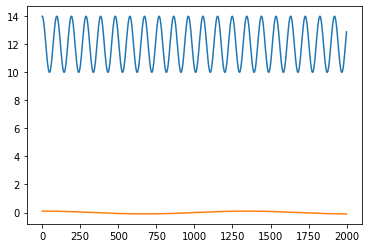

In [81]:
plt.plot(T_vir[:,0])
plt.plot(dH_signal)

In [82]:
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": dH_measures,
    "T_measures": T_measures,
    "sigma_meas_P": None, #float
    "sigma_meas_T": None, #float
}

col = Column.from_dict(col_dict)

In [83]:
try:
    col.get_depths_solve()
except ComputationOrderException as e:
    print(e)
    
try:
    col.get_all_n()
except ComputationOrderException as e:
    print(e)

compute_solve_transi has to be computed before calling get_depths_solve.
compute_mcmc has to be computed before calling get_all_n.


In [84]:
layersList_1 = layersListCreator([("Couche en sable", 0.20, 3, 0.1, 2, 4e6), ("Couche en bille", 0.40, 3.5, 0.2, 2, 4e6)])

col.compute_solve_transi(layersList_1, 100)

--- Compute Solve Transi ---
Couche en sable : ends at 0.2 m. Parametres(moinslog10K=3, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche en bille : ends at 0.4 m. Parametres(moinslog10K=3.5, n=0.2, lambda_s=2, rhos_cs=4000000.0)
Done.


nan

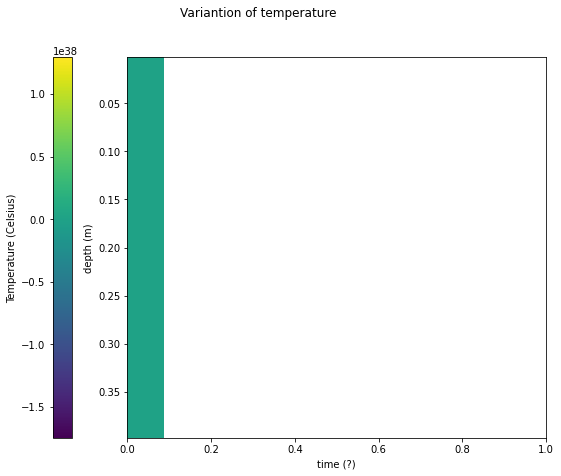

In [85]:
#Tout est stocké dans la class col pour ne pas avoir à le stocker hors de la class
fig, ax = plt.subplots(figsize=(10, 7), facecolor = 'w')

imm = ax.imshow(
    col.temps_solve - 273.15,
    aspect = "auto",
    extent = [0, 1, col.depths_solve[-1], col.depths_solve[0]], #TODO : trouver comment monter le datetime
)
cbar = fig.colorbar(imm, shrink=1,location='left')
cbar.set_label('Temperature (Celsius)')

fig.suptitle("Variantion of temperature")
ax.set_xlabel("time (?)")
ax.set_ylabel("depth (m)")
np.min(col.temps_solve)

/Users/jiangxinbei/Documents/pyheatmy2022/pyheatmy/core.py:294: RuntimeWarning: overflow encountered in true_divide
  nablaT[i, :] = (self._temps[i+1, :] - self._temps[i-1, :])/(2*dz)
/Users/jiangxinbei/Documents/pyheatmy2022/pyheatmy/core.py:294: RuntimeWarning: invalid value encountered in subtract
  nablaT[i, :] = (self._temps[i+1, :] - self._temps[i-1, :])/(2*dz)
/Users/jiangxinbei/Documents/pyheatmy2022/pyheatmy/core.py:302: RuntimeWarning: overflow encountered in multiply
  conduc_flows[i, :] = lambda_m_list[i] * nablaT[i, :]


Text(0, 0.5, 'depth (cm)??')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/image.py:479: RuntimeWarning: overflow encountered in subtract
  A_scaled -= a_min
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/image.py:480: RuntimeWarning: overflow encountered in subtract
  vrange -= a_min
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/image.py:503: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


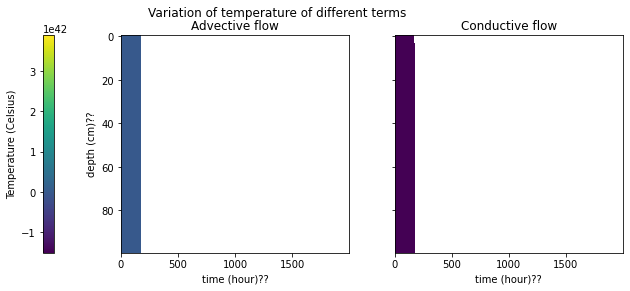

In [86]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,4), facecolor = 'w')

im = ax[0].imshow(col.advec_flows_solve, aspect='auto')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=1,location='left')
cbar.set_label('Temperature (Celsius)')

ax[1].imshow(col.conduc_flows_solve, aspect='auto')

ax[0].set_title('Advective flow')
ax[1].set_title('Conductive flow')

fig.suptitle("Variation of temperature of different terms")
for i in range(2):
    ax[i].set_xlabel("time (hour)??")

ax[0].set_ylabel("depth (cm)??")

Index 25 in z_array -> 0.10200000000000001
Index 50 in z_array -> 0.202
Index 75 in z_array -> 0.302


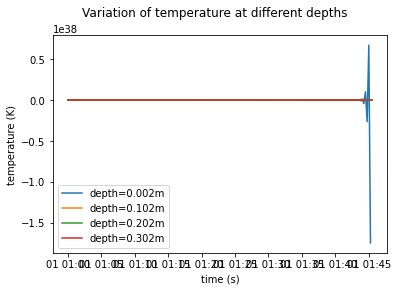

In [87]:
ind1 = 25
ind2 = 50
ind3 = 75
print(f"Index {ind1} in z_array -> {col.depths_solve[ind1]}")
print(f"Index {ind2} in z_array -> {col.depths_solve[ind2]}")
print(f"Index {ind3} in z_array -> {col.depths_solve[ind3]}")

#print(f"Temp at index {ind1} and t = 0 -> {col.temps_solve[0, ind1]:.3f}")
#print(f"Temp at {col.depths_solve[ind1]:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind1])[0]:.3f}")
#print("col.get_temps correct inaccuracy in z.")
#print(f"Temp at {col.depths_solve[ind]+1e-3:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind]+1e-4)[0]:.3f}")

fig, ax = plt.subplots(facecolor = 'w')
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[0])-273.15, label = f"depth={col.depths_solve[0]:.3f}m")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind1])-273.15, label = f"depth={col.depths_solve[ind1]:.3f}m")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind2])-273.15, label = f"depth={col.depths_solve[ind2]:.3f}m")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind3])-273.15, label = f"depth={col.depths_solve[ind3]:.3f}m")
fig.suptitle("Variation of temperature at different depths")
ax.set_xlabel("time (s)")
ax.set_ylabel("temperature (K)")
#ax.set_xlim(0,0.1)
ax.legend()